In [ ]:
import yaml
import torch
import os
os.chdir('C:/Users/clack/Projects/nwm')

from experiment.vae import make_vae
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from diffusion import create_diffusion
from isolated_nwm_infer import model_forward_wrapper
from misc import transform, unnormalize
from models import CDiT_models
from datasets import Nav2dTopoDataset

EXP_NAME = 'nwm_cdit_s'
MODEL_PATH = 'D:/nwm-out/nwm_cdit_s-topo128/checkpoints/495.pth.tar'

with open("config/data_config.yaml", "r") as f:
    default_config = yaml.safe_load(f)
config = default_config

with open(f'config/{EXP_NAME}.yaml', "r") as f:
    user_config = yaml.safe_load(f)
config.update(user_config)
latent_size = config['image_size'] // 8
print(latent_size)
print("loading model")
import pathlib
pathlib.PosixPath = pathlib.WindowsPath
model = CDiT_models['CDiT-S/2'](input_size=latent_size, context_size=config['context_size'])
ckp = torch.load(MODEL_PATH, map_location='cpu', weights_only=False) 

print(model.load_state_dict(ckp["ema"], strict=True))
model.eval()
device = 'cuda'
model.to(device)
model = torch.compile(model)

diffusion = create_diffusion(str(250))
vae = make_vae().to(device)
vae.load_state_dict(torch.load('checkpoints/vae/topo/check59.pt'))


# train_dataset = Nav2dTopoDataset(
#     size=1000,
#     resolution=config['image_size'],
#     context_size=config['context_size'],
#     goal_count=4,
#     max_step_distance=8,
#     max_angular_drift=torch.pi,
#     transform=transform
# )

c:\Users\clack\miniconda3\envs\dev\lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  self.setter(val)


16
loading model
<All keys matched successfully>


<All keys matched successfully>

In [25]:
from experiment.nav2d import Topo
import torch._dynamo
torch._dynamo.config.disable = True

state = Topo.random()
image = state.render(camera_size=128)
print(image.shape)
x_cond_pixels = transform(torch.from_numpy(image.copy()).permute(2, 0, 1)).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
y = torch.tensor([[[0.0, 0.0, 0.0]]], device=device)
# vae.encode(x_cond_pixels[0])
samples = model_forward_wrapper(
  (model, diffusion, vae),
  x_cond_pixels,
  y,
  None,
  latent_size,
  device,
  config["context_size"],
  num_goals=1,
  rel_t=torch.ones(1, device=device),
  progress=True
)

(128, 128, 3)


  0%|          | 0/250 [00:00<?, ?it/s]

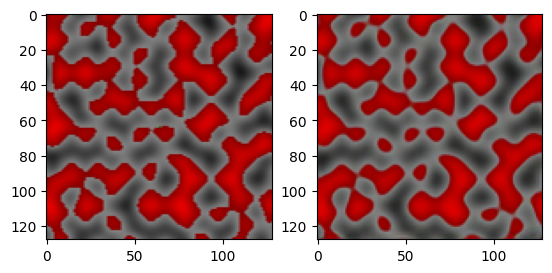

In [26]:
import matplotlib.pyplot as plt
from misc import transform, unnormalize
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[1].imshow(unnormalize(samples[0]).cpu().permute(1, 2, 0).to(dtype=torch.float32))

In [2]:
import cv2
import numpy as np
from experiment.nav2d import Topo

state = Topo.random()
CAMERA_RESOLUTION = 128
UPSCALE_RESOLUTION = 512

def render():
  return cv2.resize(
    cv2.cvtColor(
      state.render(CAMERA_RESOLUTION).astype(np.float32),
      cv2.COLOR_RGB2BGR
    ),
    (UPSCALE_RESOLUTION, UPSCALE_RESOLUTION),
    interpolation=cv2.INTER_NEAREST
  )

def on_click(event, x, y, flags, param):
  if event != cv2.EVENT_LBUTTONDOWN:
    return
  click_position = np.array([x, y]) / UPSCALE_RESOLUTION
  displacement = (click_position - 0.5) * CAMERA_RESOLUTION
  state.act(displacement)
  
  cv2.imshow('worldstate', render())

# cv2.imshow('worldstate', render())
# cv2.setMouseCallback('worldstate', on_click)
# cv2.waitKey(0)
# cv2.destroyAllWindows()